In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MF_input = np.loadtxt('dyn_MF.txt')
MF_input = MF_input*1000
MX_input = np.loadtxt('dyn_MX.txt')
MX_input = MX_input*1000

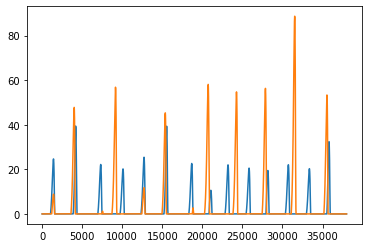

In [3]:
plt.plot(MF_input)
plt.plot(MX_input)

In [108]:
def FL_function(L):
    beta = 1.55
    omega = 0.75
    rho = 2.12
    
    FL = np.exp(-np.power(abs((np.power(L,beta) - 1)/(omega)),rho));
    return FL

def FV_con_function(L,V):
    Vmax = -9.15*2;
    cv0 = -5.7;
    cv1 = 9.18;
    
    FVcon = (Vmax - V)/(Vmax + (cv0 + cv1*L)*V);
    return FVcon

def FV_ecc_function(L,V):
    av0 = -1.4;
    av1 = 0.0;
    av2 = 0.0;
    bv = 0.72;
    FVecc = (bv - (av0 + av1*L + av2*np.power(L,2))*V)/(bv+V);
    
    return FVecc

def Fpe_function(L,V):
    c1_pe1 = 23.0*6
    k1_pe1 = 0.046
    Lr1_pe1 = 1.17
    eta = 0.0001;
    
    Fpe1 = c1_pe1 * k1_pe1 * np.log(np.exp((L - Lr1_pe1)/(k1_pe1))+1) + eta*V;
    
    return Fpe1

def Af_function(U,L):
    a = (2.0-0.5)/(1.0-0.001);
    b = 0.5-(2.0-0.5)/(1.0-0.001)*.001;
    f_eff = a*U+b;

    a_f = 0.56
    n_f0 = 2.1
    n_f1 = 3.3
    n_f = n_f0 + n_f1*(1.0/L-1.0);
    Af = 1 - np.exp(-np.power(f_eff/(a_f*n_f),n_f));
    return Af

def muscle_length_flexor(a,b,theta):
    L = np.sqrt(np.power(a,2) - 2*a*b*np.cos(theta) + np.power(b,2))
    return L

def muscle_length_extensor(a,b,theta):
    if theta > 1.63:
        L = np.sqrt(np.power(a,2) + 2*a*b*np.cos(theta) + np.power(b,2))
    else:
        L = np.sqrt(np.power(a,2)-np.power(b,2)) + b*(1.63-theta)    
    return L

def torque_flexor(a,b,theta,Fm):
    T = Fm*-a*b*np.sin(theta)/np.sqrt(np.power(a,2)-2*a*b*np.cos(theta)+np.power(b,2))
    return T

def torque_extensor(a,b,theta,Fm):
    if theta > 1.63:
        T = Fm*a*b*np.sin(theta)/np.sqrt(np.power(a,2) + 2*a*b*np.cos(theta) + np.power(b,2))
    else:
        T = Fm*b    
    return T  

def forward_dynamis(x,dx,u,I,B,a,b,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,Lt_1,Lt_2):
    # Minimum joint angle
    theta_min = 40*np.pi/180.0
    # Maximum joint angle
    theta_max = 110*np.pi/180.0
    
    # Muscle time constant (sec)
    tau_1 = 0.01;
    tau_2 = 0.01;
    
    L_1 = muscle_length_flexor(a,b,x[4])
    Lce_1 = (L_1 - Lt_1)/Lce0_1
    
    L_2 = muscle_length_extensor(a,b,x[4])
    Lce_2 = (L_2 - Lt_2)/Lce0_2
    
    FL_1 = FL_function(Lce_1)
    FL_2 = FL_function(Lce_1)
        
    Fpe_1 = Fpe_function(Lce_1/Lmax_1,0)
    Fpe_2 = Fpe_function(Lce_2/Lmax_2,0)

    Af_1 = Af_function(x[0],Lce_1)
    Af_2 = Af_function(x[2],Lce_2)
    
    Fm_1 = (FL_1*x[0]*Af_1+Fpe_1)*F0_1
    Fm_2 = (FL_2*x[2]*Af_2+Fpe_2)*F0_2
        
    T_stop_1 = 0.01*np.exp(-(x[4]-theta_min)/0.01)
    T_stop_2 = -0.01*np.exp((x[4]-theta_max)/0.01)
    
    dx[0] = x[1]
    dx[1] = -x[0]/(tau_1*tau_2) - x[1]*(tau_1+tau_2)/(tau_1*tau_2) + u[0]/(tau_1*tau_2)
    dx[2] = x[3]
    dx[3] = -x[2]/(tau_1*tau_2) - x[3]*(tau_1+tau_2)/(tau_1*tau_2) + u[1]/(tau_1*tau_2)
    dx[4] = x[5]
    dx[5] = (torque_flexor(a,b,x[4],Fm_1) + torque_extensor(a,b,x[4],Fm_2) + T_stop_1 + T_stop_2)/I - B*x[5] 

    return dx

In [109]:
Fs = 10000
h = 1/Fs
duration = len(MF_input)
time_sim = np.arange(0,duration/Fs,step = 1/Fs)

In [110]:
# Segment length (m)
L = 0.01 
# Distance between the rotational axis and the center of the segment (m)
d = 0.001
# Segment mass (kg)
M = 0.0004
# Segment inertia (kg*m^2)
I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
# Viscosity (N*m*s)
B = 200
# Distance from the rotation axis to the muscle origin (m)
a = 0.018 
# Distance from the rotation axis to the muscle insertion (m)
b = 0.001

# Minimum joint angle (radians)
theta_min = 40*np.pi/180.0
# Maximum joint angle (radians)
theta_max = 110*np.pi/180.0
# Positive angle change => dorsiflexion 

In [111]:
# Maximum muscle force (N)
F0_1 = 2.13
F0_2 = 2.13
# Optimal muscle fiber length (m)
Lce0_1 = 0.473*0.01 # Average fiber length of all dorsiflexors 
Lce0_2 = 0.473*0.01 #0.389*0.01; # Average fiber length of all plantarflexors 
# Maximum muscle fiber legnth at the anatomical limit of range of motion (i.e. minimum and maximum joint angles) (L_0)  
Lmax_1 = 1.1;
Lmax_2 = 1.1;

# Muscle time constant (ms)
tau_1 = 0.01;
tau_2 = 0.01;

# Moment arm (m)
r_m1 = 0.001 #0.0006
r_m2 = -0.001 #-0.0015

In [112]:
# Length of flexor muscle at theta_min when it is most stretched 
L_1_max = muscle_length_flexor(a,b,theta_max)
# Length of muscle fiber at the joint angle
Lm_max_1 = Lce0_1*Lmax_1
# Compute the length of tendon/aponeurosis 
Lt_1 = L_1_max - Lm_max_1

# Length of flexor muscle at theta_min when it is most stretched 
L_2_max = muscle_length_extensor(a,b,theta_min)
# Length of muscle fiber at the joint angle
Lm_max_2 = Lce0_2*Lmax_2
# Compute the length of tendon/aponeurosis 
Lt_2 = L_2_max - Lm_max_2

In [113]:
Lce_1 = np.zeros(len(theta_vec))
Fpe_1 = np.zeros(len(theta_vec))
T_1 = np.zeros(len(theta_vec))
Lce_2 = np.zeros(len(theta_vec))
Fpe_2 = np.zeros(len(theta_vec))
T_2 = np.zeros(len(theta_vec))
for i in range(0,len(theta_vec)):
    L_1 = muscle_length_flexor(a,b,theta_vec[i])
    Lce_1[i] = (L_1 - Lt_1)/Lce0_1
    Fpe_1[i] = Fpe_function(Lce_1[i]/Lmax_1,0)*F0_1
    T_1[i] = torque_flexor(a,b,theta_vec[i],Fpe_1[i])
    
    L_2 = muscle_length_extensor(a,b,theta_vec[i])
    Lce_2[i] = (L_2 - Lt_2)/Lce0_2
    Fpe_2[i] = Fpe_function(Lce_2[i]/Lmax_2,0)*F0_2
    T_2[i] = torque_extensor(a,b,theta_vec[i],Fpe_2[i])
    
eq_theta = theta_vec[np.argmin(abs(abs(T_1)-abs(T_2)))]
eq_theta*180/np.pi

74.82482482482482

In [119]:
theta = eq_theta
dtheta = 0
Lm_1 = Lce_1[np.argmin(abs(abs(T_1)-abs(T_2)))]
Lm_1 = Lm_1*Lce0_1
Lm_2 = Lce_2[np.argmin(abs(abs(T_1)-abs(T_2)))]
Lm_2 = Lm_2*Lce0_2
x = np.array([0.0, 0.0, 0.0, 0.0, theta, dtheta])
dx = np.zeros(6)
x_mat = np.zeros((int(duration),len(x)))

In [120]:
Lm_2

0.004595192145376549

In [121]:
u_1 = MF_input/300
u_2 = MX_input/300

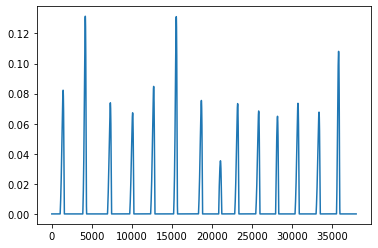

In [122]:
plt.plot(u_1)

In [123]:
t0 = time.time()
for t in range(int(duration)):
    u = np.concatenate(([u_1[t]],[u_2[t]]))
    f1 = forward_dynamis(x,dx,u,I,B,a,b,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,Lt_1,Lt_2)
    x1 = x + f1*h/2
    f2 = forward_dynamis(x1,dx,u,I,B,a,b,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,Lt_1,Lt_2)
    x2 = x + f2*h/2
    f3 = forward_dynamis(x2,dx,u,I,B,a,b,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,Lt_1,Lt_2)
    x3 = x + f3*h
    f4 = forward_dynamis(x3,dx,u,I,B,a,b,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,Lt_1,Lt_2)
    x = x + (f1+2*f2+2*f3+f4)*h/6
    x_mat[t,:] = x
                           
tf = time.time()
total = tf-t0
print(total)

8.544016122817993


(59.5842008201373, 104.68992731913843)

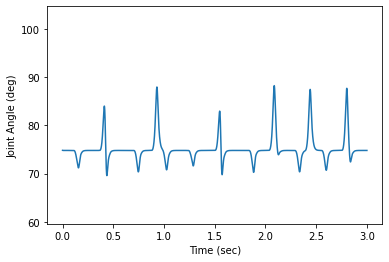

In [124]:
min_angle = np.min(np.rad2deg(x_mat[:,4]))
max_angle = np.max(np.rad2deg(x_mat[:,4]))
plt.plot(time_sim[0:30000],np.rad2deg(x_mat[0:30000,4]))
plt.ylabel('Joint Angle (deg)')
plt.xlabel('Time (sec)')
plt.ylim([min_angle-10, max_angle+10])

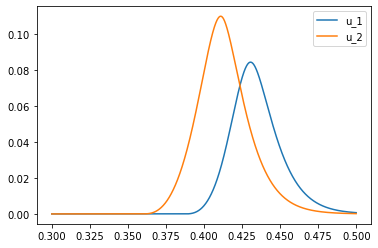

In [88]:
plt.plot(time_sim[3000:5000],x_mat[3000:5000,0],label='u_1')
plt.plot(time_sim[3000:5000],x_mat[3000:5000,2],label='u_2')
plt.legend()

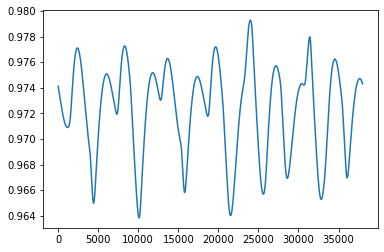

In [92]:
plt.plot(x_mat[:,7]/Lce0_1)